In [1]:
import os
import sys

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
%load_ext autoreload
%autoreload 2

## Preparing dataset and loaders

In [2]:
from torch.utils.data import DataLoader
from torchvision import transforms

from source.datasets.transforms import ToPILImage, GrayScale, Resize, ToTensor
from source.datasets.hpatches_dataset import HPatchesDataset

root_path = "/Users/apple/Documents/datasets/hpatch_v_sequence"
csv_path = "/Users/apple/Documents/datasets/hpatch_v_sequence/batch.csv"

test_transform = [ToPILImage(),
                  GrayScale(),
                  Resize((960, 1280)),
                  Resize((480, 640)),
                  ToTensor()]

dataset = HPatchesDataset(root_path, csv_path, item_transforms=transforms.Compose(test_transform), sources=True)
loader = DataLoader(dataset, 1)

## Loading model

In [3]:
import torch
from source.nn.model import NetVGG

model = NetVGG(8, 64, 15, True)

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model_path = "/Users/apple/PycharmProjects/Summertime/Net/runs/train_md_lr_3px/checkpoints/my_model_57_avg_ms_mma=0.464914.pth"

model.load_state_dict(torch.load(model_path, map_location=device))

<All keys matched successfully>

In [4]:
from source.utils.eval_utils import forward
from source.utils.eval_utils import (S_IMAGE1, S_IMAGE2,
                                     KP1,KP2, W_KP1, W_KP2,
                                     W_KP1, W_KP2, KP1_DESC, KP2_DESC,
                                     WV_KP1_MASK, WV_KP2_MASK)

# Sample one batch from loader and run detector-descriptor pipeline
endpoint = forward(model, next(loader.__iter__()), device)

In [5]:
s_image1 = endpoint[S_IMAGE1]
s_image2 = endpoint[S_IMAGE2]

kp1 = endpoint[KP1]
kp2 = endpoint[KP2]

w_kp1 = endpoint[W_KP1]
w_kp2 = endpoint[W_KP2]

wv_kp1_mask = endpoint[WV_KP1_MASK]
wv_kp2_mask = endpoint[WV_KP2_MASK]

kp1_desc = endpoint[KP1_DESC]
kp2_desc = endpoint[KP2_DESC]

In [6]:
from source.utils.eval_utils import draw_cv_keypoints, draw_cv_matches, torch2cv, plot_figures

cv_s_image1 = torch2cv(s_image1[0])
cv_s_image2 = torch2cv(s_image2[0])

cv_keypoints_s_image1 = draw_cv_keypoints(cv_s_image1, kp1[0], (0, 255, 0))
cv_keypoints_s_image2 = draw_cv_keypoints(cv_s_image2, kp2[0], (0, 255, 0))

In [7]:
detected_keypoints = {"Fisrt image keypoints": cv_keypoints_s_image1,
                      "Second image keypoints": cv_keypoints_s_image2}

plot_figures(detected_keypoints, 1, 2, (18, 9))

In [8]:
from source.utils.metric_utils import match_score
m_score1, num_matches1, num_gt_corr1, nn_desc_ids1, desc_matches1 = match_score(w_kp1, kp2, 
                                                                                wv_kp1_mask, wv_kp2_mask,
                                                                                torch.tensor([5.0]), 
                                                                                kp1_desc, kp2_desc,
                                                                                True)

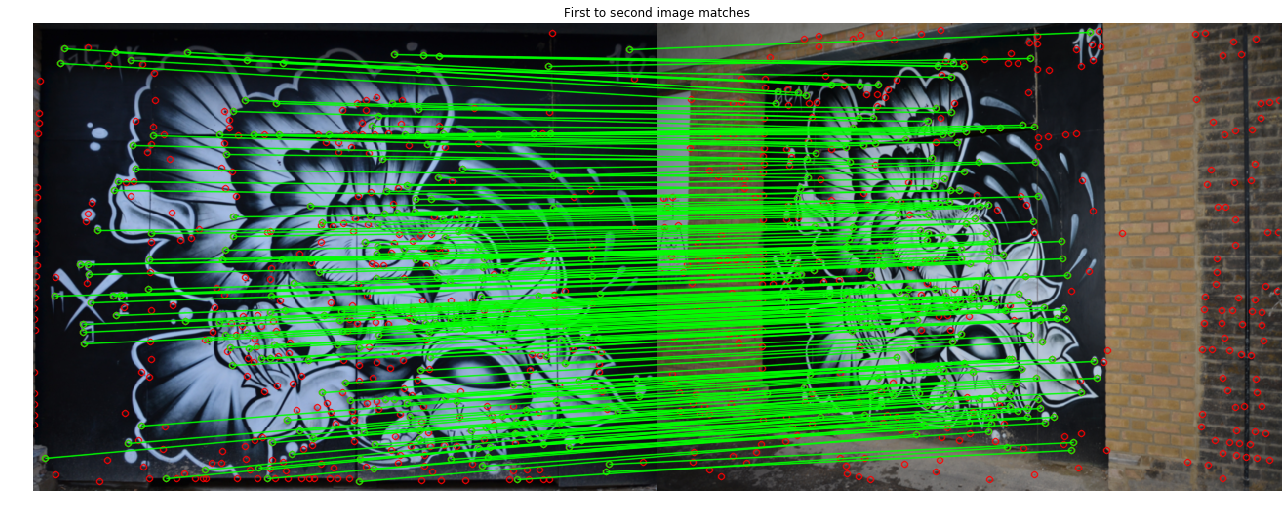

In [9]:
cv_matches1 = draw_cv_matches(cv_s_image1, cv_s_image2, kp1[0], kp2[0], nn_desc_ids1[0], 
                              desc_matches1[0][0])

detected_matches = {"First to second image matches": cv_matches1}

plot_figures(detected_matches, 1, 1, (18, 9))

In [11]:
import cv2

# Permute kp2 points according to matches
p_kp2 = torch.gather(kp2, 1, nn_desc_ids1.unsqueeze(-1).repeat(1, 1, 2))

matches_ids = desc_matches1.nonzero()[:, 2].unsqueeze(0).unsqueeze(-1).repeat(1, 1, 2)

kp1_gt = torch.gather(kp1, 1, matches_ids)
kp2_gt = torch.gather(p_kp2, 1, matches_ids)

In [22]:
from source.nn.model import NormalizedEightPointNet
from source.utils.transform_utils import transform_F_to_image_space
from source.utils.colmap_utils import compute_residual
from source.utils.eval_utils import evaluate

model_path = "/Users/apple/PycharmProjects/DeepFundamentalMatrix/checkpoints_sh/model_epoch2.pt"

model = NormalizedEightPointNet(num_iter=5)
model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))
model.to(device)

F_estimates, norm_transform1, norm_transform2 = model(kp1.float(), kp2.float(), None)
F_estimate = transform_F_to_image_space(norm_transform1, norm_transform2, F_estimates[-1]).detach()

In [23]:
F_ransac, inliers_ransac = cv2.findFundamentalMat(kp1[0].numpy(), p_kp2[0].numpy(), method=cv2.FM_RANSAC, ransacReprojThreshold=1, confidence=0.9)
F_gt, _ = cv2.findFundamentalMat(kp1_gt[0].numpy(), kp2_gt[0].numpy(), method=cv2.FM_8POINT, ransacReprojThreshold=1, confidence=0.9)

In [24]:
from numpy.random import choice

# Determine common inlier for RANSAC
ransac_common_inliers = inliers_ransac.squeeze() * desc_matches1.squeeze().numpy()
inliers_to_plot = choice(ransac_common_inliers.nonzero()[0], 15)

kp1_plot = kp1[0][inliers_to_plot, :].numpy()
kp2_plot = p_kp2[0][inliers_to_plot, :].numpy()

In [25]:
lines_ransac = cv2.computeCorrespondEpilines(kp1_plot.reshape(-1,1,2), 1, F_ransac).reshape(-1, 3)
lines_gt = cv2.computeCorrespondEpilines(kp1_plot.reshape(-1, 1, 2), 1, F_gt).reshape(-1, 3)
lines_nn = cv2.computeCorrespondEpilines(kp1_plot.reshape(-1, 1, 2), 1, F_estimate.numpy()[0]).reshape(-1, 3)

In [26]:
def drawlines(_image1, lines, color):
    image1 = _image1.copy()
    _, w, _ = image1.shape
    
    for coeffs in lines:
        x0,y0 = [int(-coeffs[2] / coeffs[1]), 0]
        x1,y1 = map(int,[-(coeffs[2] + coeffs[0] * w) / coeffs[1], w])
        
        image1 = cv2.line(image1, (x0,y0), (x1,y1), color, 2)
    
    return image1

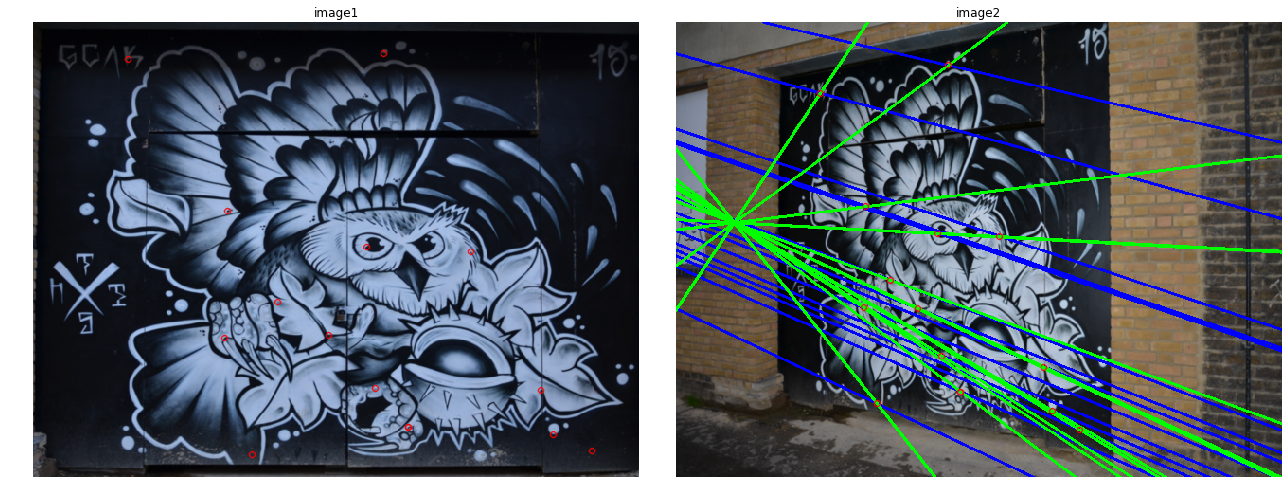

In [27]:
cv_kp2_plot = drawlines(cv_s_image2, lines_gt, (0, 0, 255))
cv_kp2_plot = drawlines(cv_kp2_plot, lines_ransac, (0, 255, 0))

cv_kp1_plot = draw_cv_keypoints(cv_s_image1, kp1_plot, (255, 0, 0))
cv_kp2_plot = draw_cv_keypoints(cv_kp2_plot, kp2_plot, (255, 0, 0))

cv_kp_plots = {"image1": cv_kp1_plot, "image2": cv_kp2_plot}

plot_figures(cv_kp_plots, 1, 2, (18, 9))

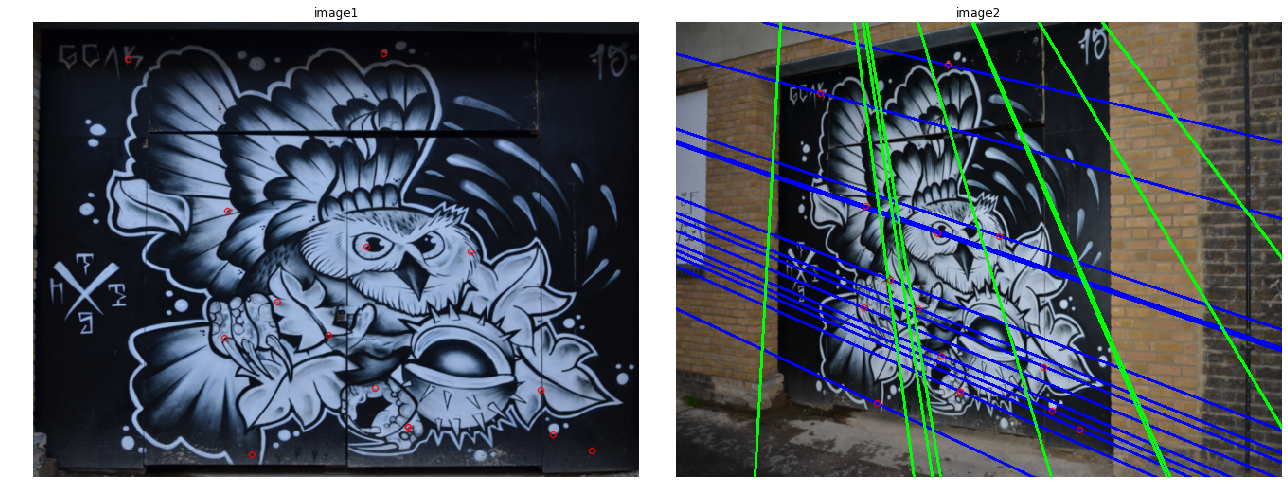

In [28]:
cv_kp2_plot = drawlines(cv_s_image2, lines_gt, (0, 0, 255))
cv_kp2_plot = drawlines(cv_kp2_plot, lines_nn, (0, 255, 0))

cv_kp1_plot = draw_cv_keypoints(cv_s_image1, kp1_plot, (255, 0, 0))
cv_kp2_plot = draw_cv_keypoints(cv_kp2_plot, kp2_plot, (255, 0, 0))

cv_kp_plots = {"image1": cv_kp1_plot, "image2": cv_kp2_plot}

plot_figures(cv_kp_plots, 1, 2, (18, 9))